# Introduction

For a company's marketing department, it is useful to know how the products are perceived by the enthuasiasts (not only the journalists) communicating on a social media. Even though they may not be the target group, who buys products, it is still good to know their attitude towards the new product.

In the notebook below I will build a pipeline that extracts the text from a product review and related forum thread in www.pistonheads.com, evaluates their sentiment/polarity and visualises the result. 
Several pre-trained models will be tested to check their performance and to pick one if the results are satisfactory. This will help to avoid using labeled dataset to train the classifier from scratch.

Here is the example of the review - https://www.pistonheads.com/road-tests/porsche/2020-porsche-taycan-turbo-s--uk-review/42115 <br>
And the forum link with the comments - https://www.pistonheads.com/gassing/topic.asp?t=1861613 <br>

Plan is following:
 - Both links will be scraped using BeautifulSoup and cleaned before passing to the model.
 - Test several models and subjectively check how well they are able to classify.
 - Run the most acceptable model and visualise sentiment distribution. 
<br>
<br>

Future improvements:
 - To implement aspect based sentiment analysis to get a more fine-grained insights on different aspects, for example price, design, handling, technology.
 - To see if there is a way to get analysis by using only article link. Right now there is no direct link in the HTML to the forum posts, even though it is visible below the article.



In [20]:
import seaborn as sns
import matplotlib
matplotlib.use('tkagg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

pd.set_option('display.max_colwidth', -1)

# Text extraction from the comments section and the article.

In [9]:
import re
import requests
from bs4 import BeautifulSoup
import lxml.html
import numpy as np

#!pip install cssselect

def get_article(URL):
    
    """

    Performs specific pistonheads.com article scraping and prepares for further use in sentiment analysis.

    """
#############################

    # Get the contents of the URL
    scraped = requests.get(URL)
    PageContent = BeautifulSoup(scraped.content, 'html.parser')

    # Get the title
    title = PageContent.find_all('h1', class_='🏎3U4qcY')
    title = lxml.html.document_fromstring(str(title)).cssselect('body')[0].text_content()
    print(str(title))
    
    # Get all paragraphs from the article
    paragraphs = PageContent.find_all('div', class_='🏎2PaxXZ')
    
    # Cleaning the paragraphs
    def extract_text(x):
        return lxml.html.document_fromstring(str(x)).cssselect('body')[0].text_content()
    
    paragraphs = list(map(lambda x: extract_text(x), paragraphs))
    paragraphs = [i for i in paragraphs if len(str(i))>110] #leave text blocks that are longer than 110 symbols
    
    print("{} paragraphs were analysed.".format(len(paragraphs)))

    
    return paragraphs

In [18]:
def get_all_posts(URL):
    
    """

    Performs a specific pistonheads.com forum thread scraping and cleans the posts
    for further use in sentiment analysis.

    """
#############################

    # Get the contents of the URL
    scraped = requests.get(URL)
    PageContent = BeautifulSoup(scraped.content, 'html.parser')

    # Get the title
    title = PageContent.find_all('div', class_='title')
    title = lxml.html.document_fromstring(str(title)).cssselect('body')[0].text_content()
    print(str(title))
    
    # find the number of pages. Limiting to 9 pages (180 posts) if the forum thread is longer than 9 pages.
    npages = PageContent.find_all('a', class_='number')
    
    
    try:
        lastPage = int(str(npages[-1])[-5])
    except:
        lastPage = 1
    
    if lastPage == 0:
        lastPage = 9 

#############################

    # If only one page, get content from it and clean it. If more - create an forum URL list to loop through.

    if lastPage == 1:
        posts = PageContent.find_all('div', class_='phml msg-body')
        
    else:
        URL_list = [URL+"+&p="+str(i) for i in range(1, lastPage+1)]
        
    # Go through all pages in URL_list and collect all posts
        posts = []
        
        for page in URL_list:            
            scraped = requests.get(page)
            PageContent = BeautifulSoup(scraped.content, 'html.parser')
            page_posts = PageContent.find_all('div', class_='phml msg-body')
            
            for post in page_posts:
                posts.append(post)

        
    print("{} posts were retrieved.".format(len(posts)))
    
#############################
                    
    #Cleaning collected posts, removing items like various HTML tags, for example <br/></div> etc.
    
    posts = [str(post)
           .replace('<div class="phml msg-body" id="message1"><div>', '')
           .replace('<br/></div> </div>', '')
           .replace("<br/><br/>", '')
           .replace("<br/>", ' ')
           for post in posts]
    
    regex_pattern = ['<d(.*)v>']
    
    posts = list(map(lambda x: re.sub(regex_pattern[0], '', x), posts))
    
    def extract_text(x):
        if len(x) > 10:
            return lxml.html.document_fromstring(str(x)).cssselect('body')[0].text_content()
    
    posts = list(map(lambda x: extract_text(x), posts))
    posts = [i for i in posts if len(str(i))>5] #Remove the posts that are less than 5 characters.

 #############################   

    print("{} posts were analysed.".format(len(posts)))
    return posts

# Test of various ready-to-use models for sentiment/polarity analysis:

FLAIR - ready to use model for from Zalando, which has achieved SOTA in several tasks when it was released. Returns polarity label and score - https://github.com/zalandoresearch/flair;

NLTK Sentiment, VADER module, returns negative, neutral, positive and compound scores - https://www.nltk.org/_modules/nltk/sentiment/vader.html;

TextBlob sentiment analysis, returns polarity and subjectivity scores - https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis





In [11]:
#!pip install --upgrade git+https://github.com/flairNLP/flair.git
#!pip install textblob

from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')

from textblob import TextBlob

import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

2020-04-17 12:18:16,013 loading file C:\Users\Andrius\.flair\models\imdb-v0.4.pt


In [12]:
def FLAIR(post):

    sentence = Sentence(post)
    classifier.predict(sentence)
    # printpredicted labels
    print('FLAIR eval:', sentence.labels)
    

    
def multimodel_eval(post):
    print(post)
    FLAIR(post)
    print("NLTK eval:", sid.polarity_scores(post))
    print("TextBLOB eval:", TextBlob(post).sentiment)
    print("\n")

In [13]:
# Test with the example

link = 'https://www.pistonheads.com/gassing/topic.asp?t=1861613'
content = get_all_posts(link)

for i in range(len(content)):
    multimodel_eval(content[i])

[RE: 2020 Porsche Taycan Turbo S | UK Review, Discussion]
170 posts were retrieved.
160 posts were analysed.
The first and only EV I actually want. Bravo Porsche.That said, I wonder how you'd feel after owning the thing for a year? There's clearly more to it than traffic-light grand prix starts, but it still seems a bit anodyne. Who knows, seems like it's the future. 
FLAIR eval: [NEGATIVE (0.9935)]
NLTK eval: {'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'compound': 0.7391}
TextBLOB eval: Sentiment(polarity=0.20833333333333334, subjectivity=0.5097222222222223)


Great review Matt. And same for me - first electric car I actually want! Maybe not in white though - and it might be a tad expensive....
FLAIR eval: [POSITIVE (1.0000)]
NLTK eval: {'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'compound': 0.69}
TextBLOB eval: Sentiment(polarity=0.09166666666666667, subjectivity=0.3347222222222222)


The ONLY thing that bugs me about this car, is Porsche's decision to add the 'turbo' moniker to it. I just

FLAIR eval: [NEGATIVE (1.0000)]
NLTK eval: {'neg': 0.034, 'neu': 0.873, 'pos': 0.092, 'compound': 0.7891}
TextBLOB eval: Sentiment(polarity=0.06291666666666666, subjectivity=0.5475961538461538)


Having owned a Tesla MX P100DL (and paid a similar amount to this Taycan for the privilege), I've done the 'fast electric car thing' and despite going back to a petrol car, for most people, I genuinely believe electric IS the future.   You come out in the morning to a full 'tank', in the case of the Tesla, a real world 300 miles.  We used a supercharger once.    Goes like hot snot.    Maintenance is not required and never servicing it does not invalidate warranty, in the case of the Tesla (seriously!).  I'd imagine Porsche won't be the same as they are all about selling more and more 'stuff' to owners.     You'll never need to replace a set of brake pads unless you drive like a tool.    Range anxiety is honestly no more a thing than in a petrol car (with the Taycan's lower range it might be, m

FLAIR eval: [POSITIVE (0.6564)]
NLTK eval: {'neg': 0.023, 'neu': 0.912, 'pos': 0.065, 'compound': 0.6076}
TextBLOB eval: Sentiment(polarity=0.10700113378684807, subjectivity=0.5002267573696145)


Range, range, range.How on earth can you justify spending £150k on something, and then not be able to drive much further than 80-90 miles from your house (as per a previous poster)?I do get the other comments about driving to Spain, etc, but really, suggesting that driving further than 80-90 miles isn't exactly an unreasonable ask. In the past year, I'd say I've done a trip almost every second weekend that is further than that, and during the week, I'm genuinely unsure, because some weeks there's been time when I haven't had to go anywhere, yet at other times it feels like I'm living in my car.ICE cars can get pretty amazing range, to be sure, which is why I'm hanging onto mine for the moment, but as soon as I see an EV that can do something like 400 or 500 miles from a charge (and I'm settled

FLAIR eval: [NEGATIVE (0.9800)]
NLTK eval: {'neg': 0.014, 'neu': 0.852, 'pos': 0.134, 'compound': 0.9692}
TextBLOB eval: Sentiment(polarity=0.22305555555555556, subjectivity=0.5476388888888889)


Just looking at the pictures, does it have a really small boot or is that a massive bag in it? Hard to tell. 
FLAIR eval: [NEGATIVE (0.9886)]
NLTK eval: {'neg': 0.065, 'neu': 0.935, 'pos': 0.0, 'compound': -0.1027}
TextBLOB eval: Sentiment(polarity=-0.18055555555555558, subjectivity=0.6472222222222221)


With the Porsche logo on it, one would hope.  
FLAIR eval: [POSITIVE (0.8240)]
NLTK eval: {'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'compound': 0.4404}
TextBLOB eval: Sentiment(polarity=0.0, subjectivity=0.0)


That is how I feel about it too. Although I don't like electric cars very much...so this could have a 1000bhp and I'd still struggle to get excited by it. It also looks as ugly as hell from the photos, but I presume(hope) that it looks better in the metal. 
FLAIR eval: [NEGATIVE (0.9653)

FLAIR eval: [NEGATIVE (1.0000)]
NLTK eval: {'neg': 0.042, 'neu': 0.817, 'pos': 0.141, 'compound': 0.7149}
TextBLOB eval: Sentiment(polarity=0.1393939393939394, subjectivity=0.5396464646464646)


The Tesla Model 3 can be likened to the Ford Model T, the Model T being the first car for the masses and the Model 3 the first BEV for the masses. Just look how cars have developed since the Model T, BEV are just starting on that journey. New battery/motor technologies are just round the corner and Tesla will be making an announcement about a future battery very soon.The Taycan looks a fantastic vehicle and I believe Porsche are aiming for existing/previous Porsche customers not the masses.The size of the front brakes are for functionality, giving the driver confidence when needed, anything less would be inadequate.Room for ICE and BEV to coexist at the moment giving everybody a choice 
FLAIR eval: [POSITIVE (0.9969)]
NLTK eval: {'neg': 0.0, 'neu': 0.903, 'pos': 0.097, 'compound': 0.8934}
TextB

FLAIR eval: [NEGATIVE (0.9982)]
NLTK eval: {'neg': 0.049, 'neu': 0.733, 'pos': 0.217, 'compound': 0.9822}
TextBLOB eval: Sentiment(polarity=0.1840665154950869, subjectivity=0.49678382464096754)


Where are it? It’s already used pretty widely by buses and is certainly available in some petrol stations already.  I think it will at least complement EV and may become a proper alternative where people aren’t able to overnight charge.
FLAIR eval: [NEGATIVE (0.5533)]
NLTK eval: {'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.6808}
TextBLOB eval: Sentiment(polarity=0.125, subjectivity=0.4875)


Glad I've had three decades of petrol powered cars. With a bit of luck when electric cars are universal I will be six feet under. When I look at Porsche's back catalogue this is just massively underwhelming. I'm not sure how Porsche, Ferrari, Lamborghini etc will survive electrification. Why will enthusiasts want to buy them?
FLAIR eval: [NEGATIVE (1.0000)]
NLTK eval: {'neg': 0.033, 'neu': 0.801,

FLAIR eval: [NEGATIVE (0.9785)]
NLTK eval: {'neg': 0.045, 'neu': 0.844, 'pos': 0.111, 'compound': 0.6605}
TextBLOB eval: Sentiment(polarity=-0.01607142857142857, subjectivity=0.37589285714285714)


Absolutely no comparison at all. A turbo is a turbo: we're not talking vacuum cleaners or razors here, these are cars. If you attach 'turbo' to the end of your vehicle's name - logic dictates that said vehicle ain't gonna clean up your dogs fur from the floor, nor remove the last vestiges of fluff from the corner of your jaw. Attaching said moniker then to a fuggin' electric vehicle, is absolutely as beyond ludicrous to a semi-sensical appreciator of CARS, as it is to sticking a 'Greta Approved' sticker to the side of your fuggin' Hellcat! Oh, and this is absolutely no-way an idle rant against Porsche, as I bought my very first (and still owned!) Porker 18 and a half years ago as a 30th birthday present to myself. I still own and love it to this day and will be giving it one last fling up th

FLAIR eval: [NEGATIVE (0.7766)]
NLTK eval: {'neg': 0.05, 'neu': 0.849, 'pos': 0.101, 'compound': 0.7184}
TextBLOB eval: Sentiment(polarity=0.27186147186147186, subjectivity=0.483982683982684)


I don’t think Porsche is trying to make a profit on Tycans, or sell a million of them. I think it’s more about introducing the concept to their market. Getting people used to the idea via this halo EV model. Then a few years down the line when the more mainstream (for Porsche) models come out people will be more ready to accept them. Also it’s building EV expertise, experience and supply chains in the company. That’s all the Tycan is for IMO. Although for the record I wouldn’t say no 
FLAIR eval: [NEGATIVE (0.9276)]
NLTK eval: {'neg': 0.024, 'neu': 0.883, 'pos': 0.093, 'compound': 0.7474}
TextBLOB eval: Sentiment(polarity=0.22407407407407406, subjectivity=0.39814814814814814)


I love it except for the wheels. All wheel designs for these are not to my liking.  
FLAIR eval: [POSITIVE (0.9998)]
NL

FLAIR eval: [NEGATIVE (0.9900)]
NLTK eval: {'neg': 0.05, 'neu': 0.786, 'pos': 0.164, 'compound': 0.9372}
TextBLOB eval: Sentiment(polarity=0.11101010101010102, subjectivity=0.48363636363636364)


It is November 2018, Porsche CEO, Oliver Blume, and chief designer, Michael Mauer, are having a conference call.  Oliver Blume (OB): “So, Michael, how is the styling of the Taycan progressing?” Michael Mauer (MM): “Very well, it’s all done. I did it this morning - I had some free time while preparing the kids’ breakfast.” OB: “OK, this is good news. But out of interest, why did you allocate more time than usual?” MM: “Well, you know, it’s a new model, so I wanted to make sure it’s perfect.” OB: “Of course. So, what can we expect, a Porsche that looks radical and exciting?” MM: “Absolutely! I started with the outline of the forthcoming 992.” OB: “Ooo!” MM: “But, I have given it four doors, made it a little wider, reduced the overhangs - both front and rear! - and lengthened the wheelbase.” OB: 

FLAIR eval: [POSITIVE (0.8375)]
NLTK eval: {'neg': 0.0, 'neu': 0.888, 'pos': 0.112, 'compound': 0.9368}
TextBLOB eval: Sentiment(polarity=0.1278846153846154, subjectivity=0.3384615384615384)


Madness to buy a Porsche EV while there are still ICE available. 
FLAIR eval: [POSITIVE (0.9928)]
NLTK eval: {'neg': 0.225, 'neu': 0.775, 'pos': 0.0, 'compound': -0.4404}
TextBLOB eval: Sentiment(polarity=0.4, subjectivity=0.4)


most buying these will lease them on their company. They will be middle managers upwards to company owners as before with the Panamera, S-Class or 7-series before. They use them to drive from and to work or visit some nearby customers.  If they need to do lots long distance traveling, they either lease a Panamera or actually lease both, or take a plane. If they do long weekends, they use one of their other long-distance capable diesel of petrol barges. Very few except leasing and fleet operators will buy these, Panamera included, anyhow. The road damage caused by a 2.3 t

FLAIR eval: [NEGATIVE (1.0000)]
NLTK eval: {'neg': 0.09, 'neu': 0.91, 'pos': 0.0, 'compound': -0.8271}
TextBLOB eval: Sentiment(polarity=-0.015624999999999997, subjectivity=0.259375)


Hmm.. there's no CCS port in the photo in the article though?
FLAIR eval: [NEGATIVE (0.9713)]
NLTK eval: {'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'compound': -0.296}
TextBLOB eval: Sentiment(polarity=0.0, subjectivity=0.0)


Type 2 CCS AC on drivers side Type 2 CCS AC/DC Combo on passenger side 
FLAIR eval: [NEGATIVE (0.9949)]
NLTK eval: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
TextBLOB eval: Sentiment(polarity=0.0, subjectivity=0.0)


Basically everything you have said is wrong:EVs are no more damaging to build than an ICE vehicle, they are mainly made of the same stuff and are about 10% heavier like for like.Electricity networks are much cleaner than an ICE engine, the UKs is 55% low carbon and the rest is gas. France, Sweden or Norway's grids are near totally zero carbon.Tesla's hold thei

After evaluating several forum threads, it is pretty clear, that FLAIR tends to have a strong opinion to either side, even when the post could be classified as neutral, here are several examples:

<b>Not as positive as FLAIR would suggest:</b><br>
<i>"I love the interior but those cup holders are a big no from me. Please bring back the folding cup holders in the 997. They were the work of a genius."</i> <br>
FLAIR eval [POSITIVE (1.0000)] <br>
NLTK eval: {'neg': 0.084, 'neu': 0.75, 'pos': 0.166, 'compound': 0.4118}<br>
TextBLOB eval: Sentiment(polarity=0.16666666666666666, subjectivity=0.2333333333333333)

<b>Not as negative as FLAIR would suggest:</b><br>
<i>"Theres not many cars that come out that make me sit up and take note - I couldn't even be bothered reading past the first paragraph about the new Defender. But this... that is a car I'd be straight out to buy if I got a lottery win without thinking about it."</i> <br>
FLAIR eval [NEGATIVE (0.9954)]<br>
NLTK eval: {'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'compound': 0.7942}<br>
TextBLOB eval: Sentiment(polarity=0.14772727272727273, subjectivity=0.38964646464646463)

<b>Not as positive as FLAIR would suggest:</b><br>
<i>"Your analogy is as bizzare as it is nonsensical."</i> <br>
FLAIR eval [POSITIVE (0.9530)]<br>
NLTK eval: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}<br>
TextBLOB eval: Sentiment(polarity=0.0, subjectivity=0.0)


It is good to have a neutral class especially when algorithm has to deal with a more nuanced text.

NLTK sentiment predictions will be used for further analysis as this model performs similarly to FLAIR when there is a clear post sentiment polarity and tends to be neutral side when it is neutral/unclear.

## Let's look at the posts that are neutral or close to neutral

In [14]:
def view_neutral_posts(content):
    
    scores = [sid.polarity_scores(post)['compound'] for post in content]
    data = {'post' : content, 'score' : scores}
    df = pd.DataFrame(data=data)
    around_neutral = df[(df.score <0.2) & (df.score > -0.2)]
    print(len(around_neutral))
    return around_neutral


view_neutral_posts(content)

35


post  \
2    The ONLY thing that bugs me about this car, is Porsche's decision to add the 'turbo' moniker to it. I just can't get past the fact of how daft it sounds calling an EV a 'turbo'! Other than that - rock on Porsche!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
6    I know it's subjective, but IMO this is about as far from 'cool' as it's possible to be.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

It makes sense to remove completely neutral scores (score = 0) when visualising sentiment scores as these posts are hardly informative.

# Sentiment visualisation



In [15]:
# Function to to visualise article's paragraphs sentiment. 

def article_sentiment_viz(paragraphs):
    scores = [sid.polarity_scores(paragraph)['compound'] for paragraph in paragraphs]
    scores = [i for i in scores if i!=0] #removing 0 scores
    sns.distplot([i for i in scores if i < -0.2], color="salmon", kde=False) #negative group
    sns.distplot([i for i in scores if i > 0.2], color="green", kde=False) #positive group
    sns.distplot([i for i in scores if (i < 0.2) and (i > -0.2)], color="orange", kde=False) #neutral group
    plt.vlines(x=np.mean(scores), ymin=0, ymax=10, color="red", label='Average')
    plt.title("Article average sentiment score of {:.2f} (red line)" .format(np.mean(scores)))

# Function to to visualise forum thread overview.

def posts_sentiment_viz(posts):
    scores = [sid.polarity_scores(post)['compound'] for post in posts]
    scores = [i for i in scores if i!=0] #removing 0 scores
    sns.distplot([i for i in scores if i < -0.2], color="salmon", kde=False) #negative group
    sns.distplot([i for i in scores if i > 0.2], color="green", kde=False) #positive group
    sns.distplot([i for i in scores if (i < 0.2) and (i > -0.2)], color="orange", kde=False) #neutral group
    plt.vlines(x=np.mean(scores), ymin=0, ymax=25, color="red", label='Average')
    plt.title("Forum average sentiment score of {:.2f} (red line)" .format(np.mean(scores)))


# Final product


In [23]:
"""
Pipeline that uses a list of links, retrieves information and visualises sentiment in article
paragraphs and forum posts.

"""

def article_forum_sentiment(all_links):
    
    links = []
    for link in all_links:
        links.append(link)
    
    for i in links:
        paragraphs = get_article(i[0])
        article_sentiment_viz(paragraphs)
        plt.show()
        

        posts = get_all_posts(i[1])
        posts_sentiment_viz(posts)
        plt.show()
        
        print("*********************************************\n")

[2020 Porsche Taycan Turbo S | UK Review]
17 paragraphs were analysed.


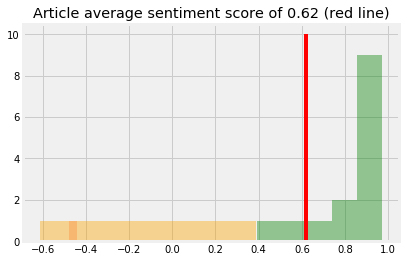

[RE: 2020 Porsche Taycan Turbo S | UK Review, Discussion]
170 posts were retrieved.
160 posts were analysed.


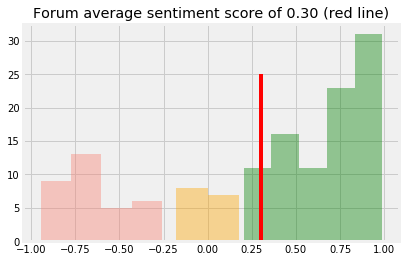

*********************************************

[2020 Porsche 911 Carrera 4S Cabriolet | UK Review]
13 paragraphs were analysed.


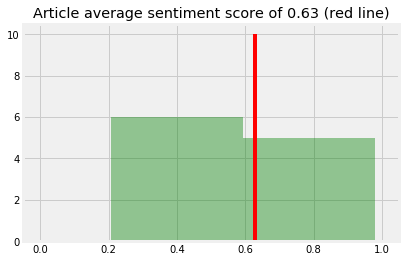

[RE: Porsche 911 Carrera 4S Cabriolet | Driven, Discussion]
36 posts were retrieved.
35 posts were analysed.


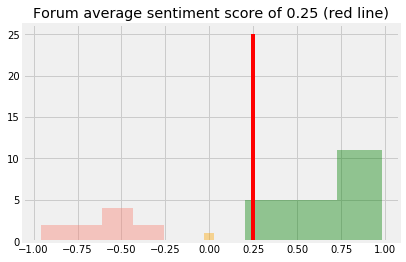

*********************************************

[2020 Porsche Macan Turbo | PH Review]
10 paragraphs were analysed.


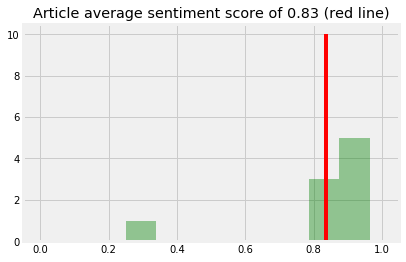

[Porsche Macan Turbo | Driven, Discussion]
71 posts were retrieved.
70 posts were analysed.


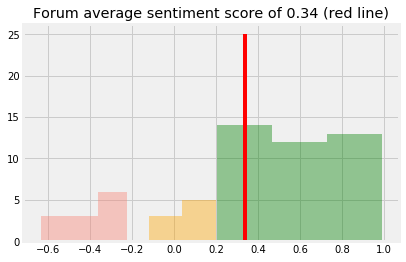

*********************************************



In [24]:
P_Taycan_turbo = ['https://www.pistonheads.com/road-tests/porsche/2020-porsche-taycan-turbo-s--uk-review/42115', 'https://www.pistonheads.com/gassing/topic.asp?t=1861613']
P_911_targa = ["https://www.pistonheads.com/news/ph-driven/2020-porsche-911-carrera-4s-cabriolet--uk-review/41400", "https://www.pistonheads.com/gassing/topic.asp?t=1843312"]
P_Macan_turbo = ["https://www.pistonheads.com/news/ph-driven/2020-porsche-macan-turbo--ph-review/41540", "https://www.pistonheads.com/gassing/topic.asp?t=1846006"]

article_names = [P_Taycan_turbo, P_911_targa, P_Macan_turbo]

article_forum_sentiment(article_names)
